In [17]:
import sys
import seaborn as sns
import os
import glob
from matplotlib import pyplot as plt
import numpy as np
import plot as pltfn
from sklearn.cluster import KMeans
from scipy import stats
import admin_functions as adfn
import networkx as nx
import network as netfn
#plt.style.use('dark_background')
sns.reset_orig()
%load_ext autoreload
%autoreload

sns.reset_orig()
#plt.style.use('dark_background')


# Define paths
#---------------------------------------------------------------------------
Fdrop = '/Users/dominicburrows/Dropbox/PhD/analysis/'
Fmac = '/Users/dominicburrows/Documents/'
F10t = '/Volumes/Dominic 10tb/'
Ffig = '/Users/dominicburrows/Dropbox/PhD/figures/'
Ftm = '/Volumes/Dominic Time Machine/'
experiment = 'PTZ-WILDTYPE'
savepath = Fdrop + 'Project/' + experiment + os.sep 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Create lists of trace data
#---------------------------------------------------------------------------
experiment = 'PTZ-WILDTYPE'
os.chdir(Fdrop + 'Project/' + experiment)
blnraw = sorted(glob.glob('*BLN*_cutrealtrace.npy'))
p20raw = sorted(glob.glob('*PTZ20*_cutrealtrace.npy'))
blnbin = sorted(glob.glob('*BLN*binarised.npy'))
p20bin = sorted(glob.glob('*PTZ20*binarised.npy'))
blnnnb = sorted(glob.glob('*BLN*nnb*'))
p20nnb = sorted(glob.glob('*PTZ20*nnb*'))
blnraw, p20raw
blnbin, p20bin

(['PTZ-WILDTYPE-02_2photon_sess-01-6dpf_BLN_run-01_0.590binarised.npy',
  'PTZ-WILDTYPE-03_2photon_sess-01-6dpf_BLN_run-01_0.590binarised.npy',
  'PTZ-WILDTYPE-04_2photon_sess-01-6dpf_BLN_run-01_0.590binarised.npy',
  'PTZ-WILDTYPE-05_2photon_sess-01-6dpf_BLN_run-01_0.590binarised.npy',
  'PTZ-WILDTYPE-06_2photon_sess-01-6dpf_BLN_run-01_0.590binarised.npy',
  'PTZ-WILDTYPE-07_2photon_sess-01-6dpf_BLN_run-01_0.590binarised.npy',
  'PTZ-WILDTYPE-08_2photon_sess-01-6dpf_BLN_run-01_0.590binarised.npy',
  'PTZ-WILDTYPE-09_2photon_sess-01-6dpf_BLN_run-01_0.590binarised.npy',
  'PTZ-WILDTYPE-10_2photon_sess-01-6dpf_BLN_run-01_0.590binarised.npy',
  'PTZ-WILDTYPE-11_2photon_sess-01-6dpf_BLN_run-01_0.590binarised.npy',
  'PTZ-WILDTYPE-12_2photon_sess-01-6dpf_BLN_run-09_0.590binarised.npy'],
 ['PTZ-WILDTYPE-02_2photon_sess-01-6dpf_PTZ20_run-01_0.590binarised.npy',
  'PTZ-WILDTYPE-03_2photon_sess-01-6dpf_PTZ20_run-01_0.590binarised.npy',
  'PTZ-WILDTYPE-04_2photon_sess-01-6dpf_PTZ20_run-01_0.590b

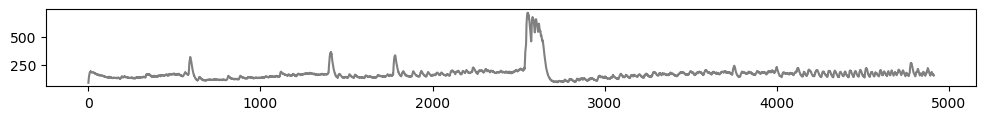

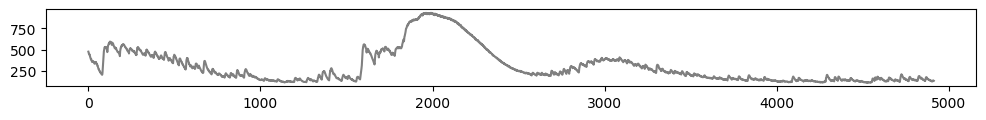

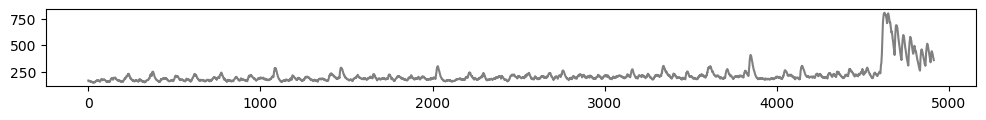

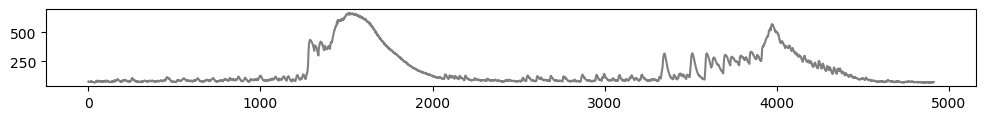

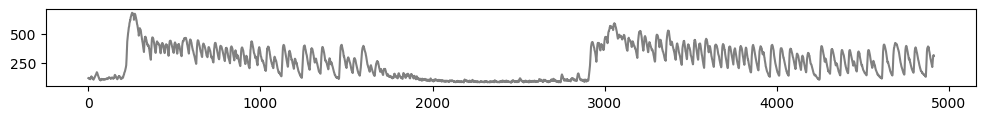

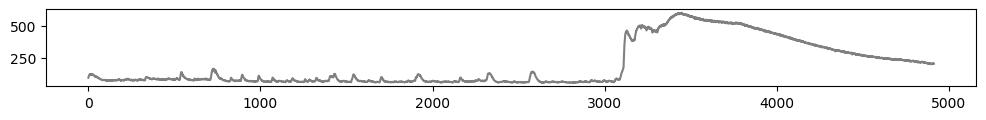

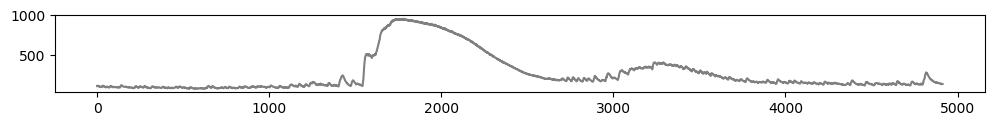

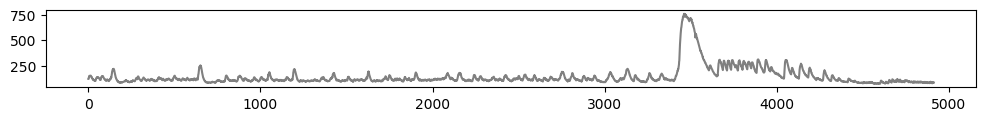

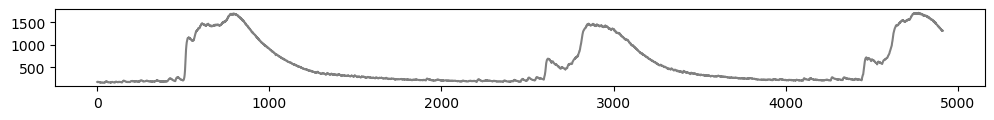

(array(['PTZ-WILDTYPE-02_2photon_sess-01-6dpf_PTZ20_run-01_cutrealtrace.npy',
        'PTZ-WILDTYPE-04_2photon_sess-01-6dpf_PTZ20_run-01_cutrealtrace.npy',
        'PTZ-WILDTYPE-05_2photon_sess-01-6dpf_PTZ20_run-01_cutrealtrace.npy',
        'PTZ-WILDTYPE-07_2photon_sess-01-6dpf_PTZ20_run-01_cutrealtrace.npy',
        'PTZ-WILDTYPE-08_2photon_sess-01-6dpf_PTZ20_run-01_cutrealtrace.npy',
        'PTZ-WILDTYPE-09_2photon_sess-01-6dpf_PTZ20_run-01_cutrealtrace.npy',
        'PTZ-WILDTYPE-10_2photon_sess-01-6dpf_PTZ20_run-01_cutrealtrace.npy',
        'PTZ-WILDTYPE-11_2photon_sess-01-6dpf_PTZ20_run-01_cutrealtrace.npy',
        'PTZ-WILDTYPE-12_2photon_sess-01-6dpf_PTZ20_run-01_cutrealtrace.npy'],
       dtype='<U66'),
 array(['PTZ-WILDTYPE-02_2photon_sess-01-6dpf_PTZ20_run-01_0.590binarised.npy',
        'PTZ-WILDTYPE-04_2photon_sess-01-6dpf_PTZ20_run-01_0.590binarised.npy',
        'PTZ-WILDTYPE-05_2photon_sess-01-6dpf_PTZ20_run-01_0.590binarised.npy',
        'PTZ-WILDTYPE-07_2photon_se

In [3]:
#which traces have clear pre-ictal and generalised periods
gen_list, sub_bln_list , gen_blist, sub_bln_blist, gen_nnblist, sub_bln_nnblist = [],[],[],[],[],[]
for o in range(len(p20raw)):
    p20 = np.load(p20raw[o])
    mean = np.apply_along_axis(np.mean, 0, p20)
    mini, maxi = np.min(mean), np.max(mean)
    if 4*mini < maxi:
        fig, ax = plt.subplots(figsize= (12,1))  
        plt.plot(mean, c='grey')
        gen_list = np.append(gen_list, p20raw[o])
        gen_blist = np.append(gen_blist, p20bin[o])
        gen_nnblist = np.append(gen_nnblist, p20nnb[o])
        sub_bln_list = np.append(sub_bln_list, blnraw[o])
        sub_bln_blist = np.append(sub_bln_blist, blnbin[o])
        sub_bln_nnblist = np.append(sub_bln_nnblist, blnnnb[o])
        plt.show()
gen_list, gen_blist, gen_nnblist

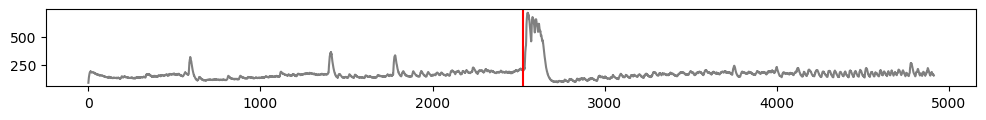

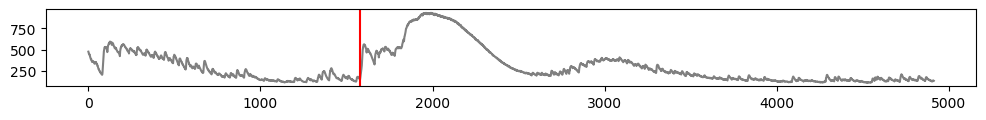

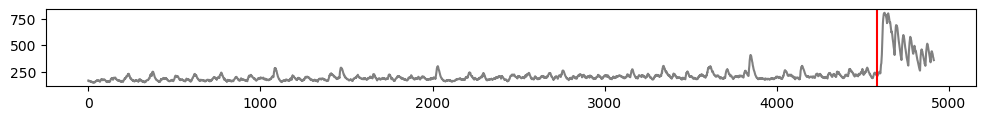

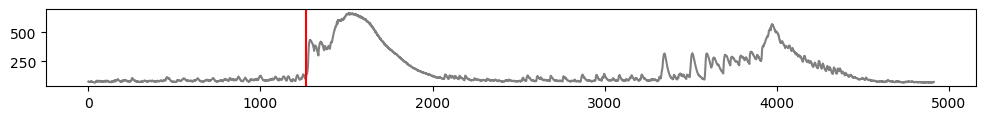

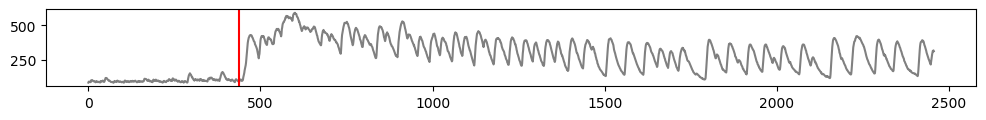

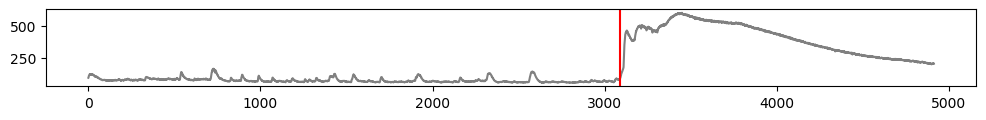

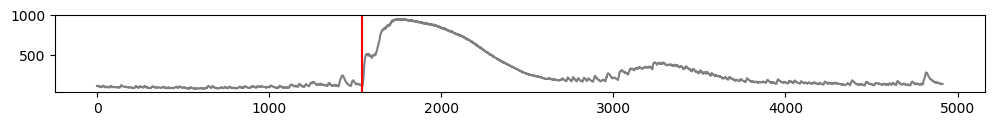

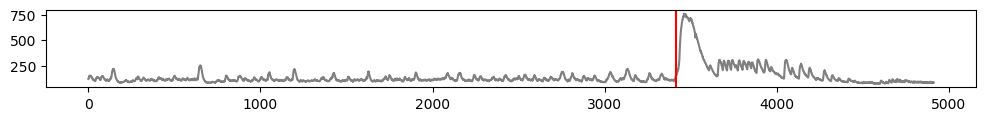

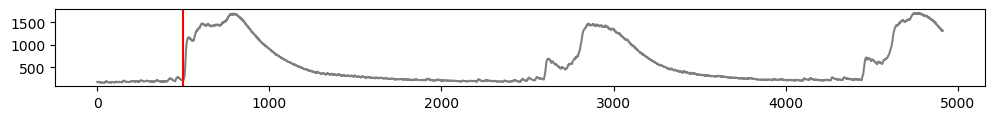

In [4]:
#IDENTIFY GENERALISED EVENT
max_list = list(range(len(gen_list)))
for o in range(len(gen_list)):
    p20 = np.load(gen_list[o])
    mean = np.apply_along_axis(np.mean, 0, p20)
    if o == 4:
        mean = mean[np.int(mean.shape[0]/2):]
    window = adfn.window(30, mean.shape[0])[0]
    diffs = list(range(mean.shape[0] - window))
    for t in range(mean.shape[0]):
        if t == mean.shape[0] - window:
            break
        diff_vec = np.zeros(window)
        for e in range(window):
            diff_vec[e] = mean[t+e] - mean[t] 
        diffs[t] = diff_vec
    
    sums, maxs = list(range(len(diffs))),list(range(len(diffs)))
    for i in range(len(diffs)):
        maxs[i] = np.max(diffs[i])

    fig, ax = plt.subplots(figsize= (12,1))  
    when = np.where(maxs ==  np.max(maxs))[0]
    plt.plot(mean, c = 'grey')
    for x in when: plt.axvline(x=x, c='red')
    max_list[o] = np.where(maxs ==  np.max(maxs))[0]
    plt.show()

In [5]:
#Time series for baseline, preictal, ictal analysis
import random
window = 400
bln_list, bln_blist = list(range(len(gen_list))),list(range(len(gen_list)))
pre_list, pre_blist = list(range(len(gen_list))),list(range(len(gen_list)))
p20_list, p20_blist = list(range(len(gen_list))),list(range(len(gen_list)))

for e in range(len(gen_list)):
    bln_ran = random.randint(0,4914-window)
    bln_list[e] = np.load(sub_bln_list[e])[:,bln_ran:bln_ran+window]
    bln_blist[e] = np.load(sub_bln_blist[e])[:,bln_ran:bln_ran+window]
    if e == 4:
        pre_list[e] = np.load(gen_list[e])[:,np.int(4914/2)+max_list[e][0]-window:np.int(4914/2)+max_list[e][0]]
        pre_blist[e] = np.load(gen_blist[e])[:,np.int(4914/2)+max_list[e][0]-window:np.int(4914/2)+max_list[e][0]]
        p20_list[e] = np.load(gen_list[e])[:,np.int(4914/2)+max_list[e][0]:np.int(4914/2)+max_list[e][0]+window]
        p20_blist[e] = np.load(gen_blist[e])[:,np.int(4914/2)+max_list[e][0]:np.int(4914/2)+max_list[e][0]+window]
    else:
        pre_list[e] = np.load(gen_list[e])[:,max_list[e][0]-window:max_list[e][0]]
        pre_blist[e] = np.load(gen_blist[e])[:,max_list[e][0]-window:max_list[e][0]]
        p20_list[e] = np.load(gen_list[e])[:,max_list[e][0]:max_list[e][0]+window]
        p20_blist[e] = np.load(gen_blist[e])[:,max_list[e][0]:max_list[e][0]+window]

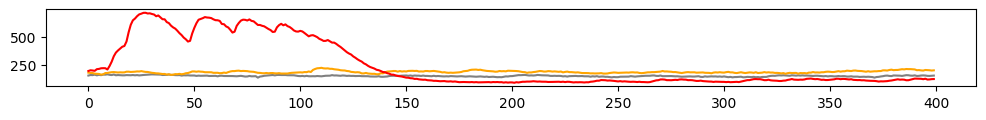

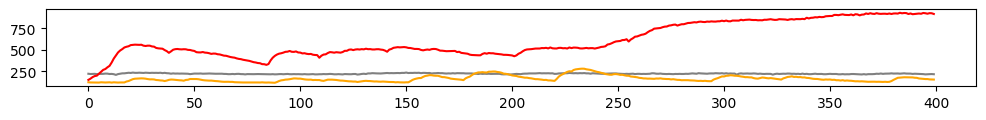

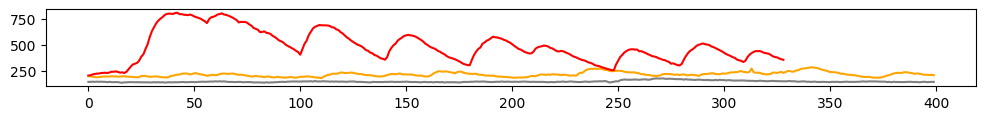

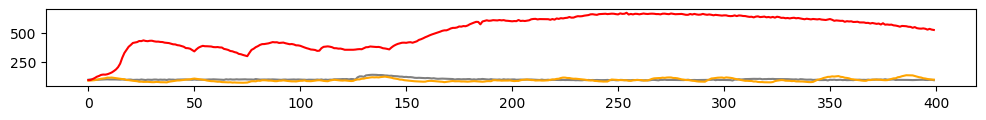

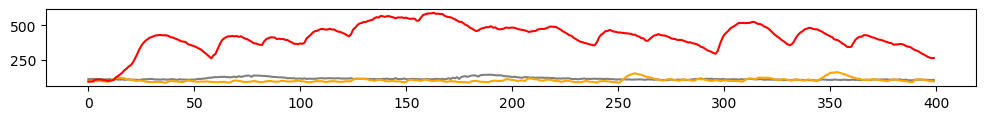

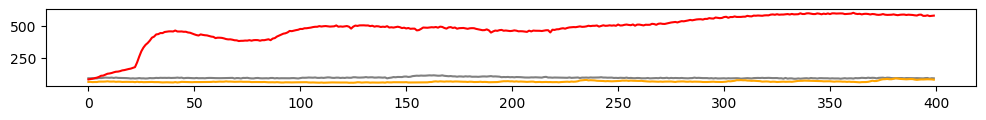

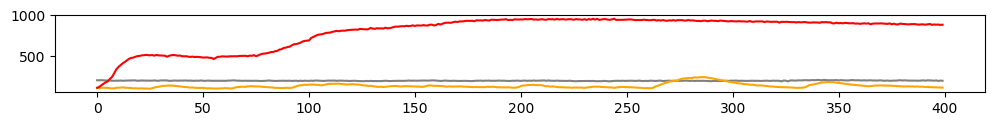

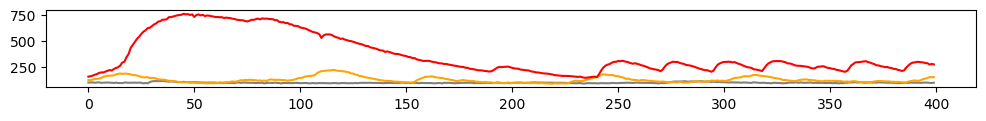

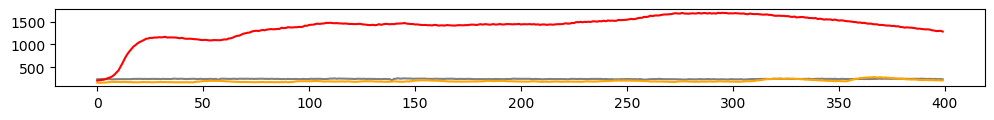

In [6]:
#Check time series
for i in range(len(bln_list)):
    fig, ax = plt.subplots(figsize= (12,1))  
    mean = np.apply_along_axis(np.mean, 0, bln_list[i])
    plt.plot(mean, c='grey')
    mean = np.apply_along_axis(np.mean, 0, pre_list[i])
    plt.plot(mean, c='orange')
    mean = np.apply_along_axis(np.mean, 0, p20_list[i])
    plt.plot(mean, c='red')
    plt.show()

In [7]:
#PCA VAR
from sklearn import decomposition
bln_pcv, pre_pcv, p20_pcv = list(range(len(bln_list))),list(range(len(bln_list))),list(range(len(bln_list)))
for i in range(len(bln_list)):
    b_data,pre_data,p20_data = bln_list[i], pre_list[i], p20_list[i]
    b_components, pre_components, p20_components = b_data.shape[1], pre_data.shape[1], p20_data.shape[1]
    b_pca, pre_pca, p20_pca = decomposition.PCA(b_components) ,decomposition.PCA(pre_components), decomposition.PCA(p20_components) #Define decomposition
    b_fit, pre_fit, p20_fit = b_pca.fit(b_data) ,pre_pca.fit(pre_data),p20_pca.fit(p20_data) 
    bln_pcv[i], pre_pcv[i], p20_pcv[i] = b_fit.explained_variance_ratio_, pre_fit.explained_variance_ratio_, p20_fit.explained_variance_ratio_

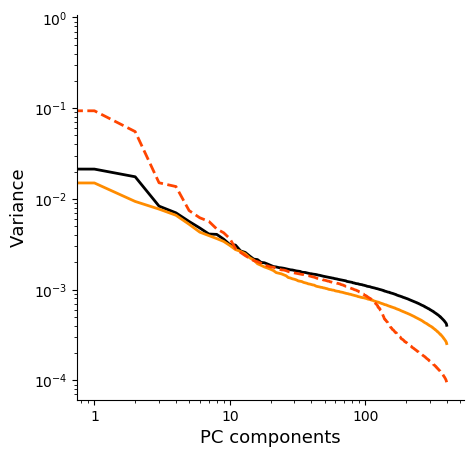

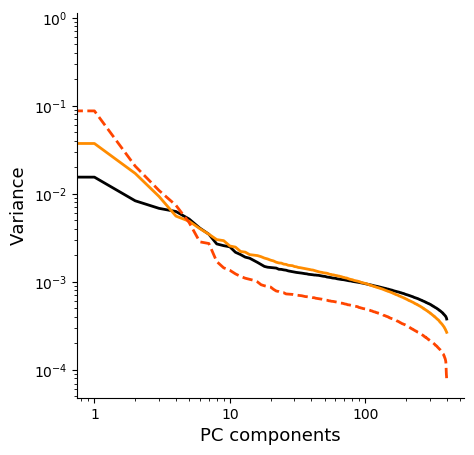

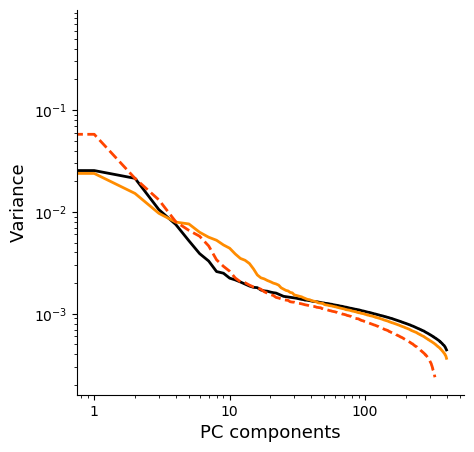

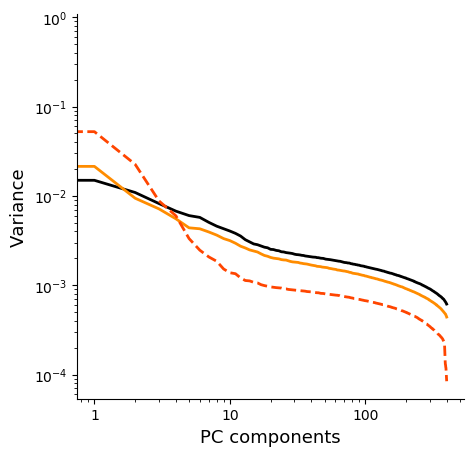

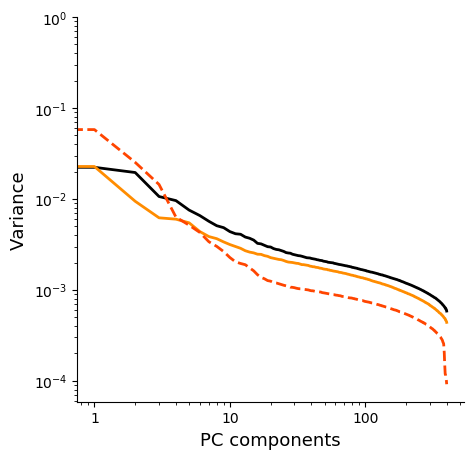

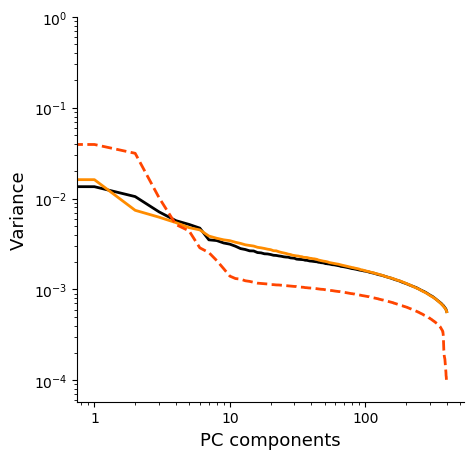

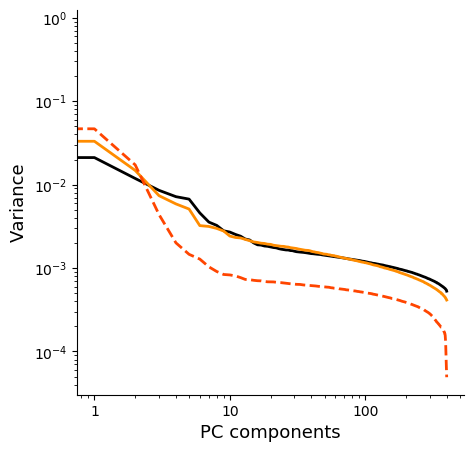

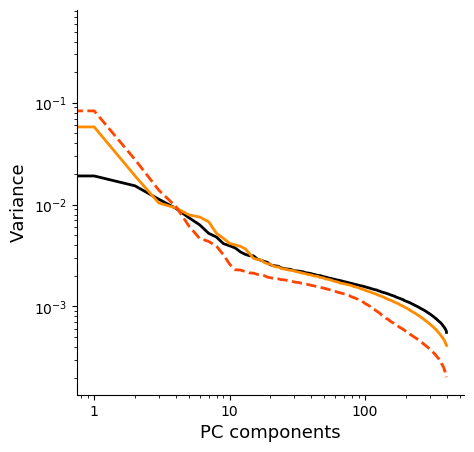

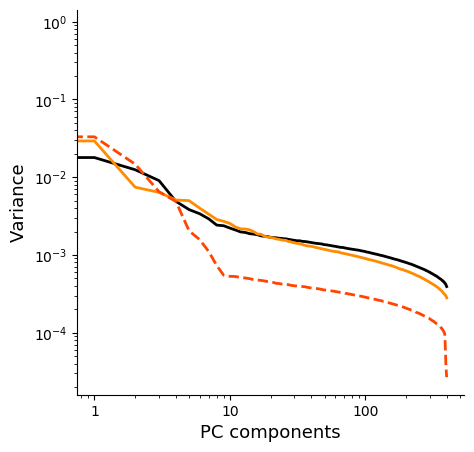

In [151]:
import matplotlib
import powerlaw
from scipy import stats
sns.reset_orig()
b_slope, pre_slope, p20_slope = list(range(len(bln_pcv))), list(range(len(bln_pcv))), list(range(len(bln_pcv)))
b2_slope, pre2_slope, p202_slope = list(range(len(bln_pcv))), list(range(len(bln_pcv))), list(range(len(bln_pcv)))

cutoff = 300

colors = ['black', 'darkorange','orangered']
lines = ['-', '-', '--']
count=0
for i in range(len(bln_pcv)):
    plotlist = [bln_pcv,pre_pcv,p20_pcv]
    slopelist = [b_slope,pre_slope,p20_slope]
    slope2list = [b2_slope,pre2_slope,p202_slope]
    fig, axarr = plt.subplots(figsize = (5,5))
    for e in range(len(plotlist)):
        data = plotlist[e][i]
        xaxis = np.linspace(0,np.shape(data)[0], num = np.shape(data)[0]+1)
        yaxis = data
        axarr.plot(xaxis[:len(xaxis)-1], yaxis[:len(xaxis)-1], '-', linewidth = 2, markersize = 1, alpha = 1, color = colors[e], linestyle = lines[e])
        slopelist[e][count] = -1*stats.linregress(np.log10(xaxis[:len(xaxis)-1][1:]),np.log10(yaxis[:len(xaxis)-1][1:]))[0]
        slope2list[e][count] = [-1*stats.linregress(np.log10(xaxis[:len(xaxis)-1][1:cutoff]),np.log10(yaxis[:len(xaxis)-1][1:cutoff]))[0], -1*stats.linregress(np.log10(xaxis[:len(xaxis)-1][cutoff:]),np.log10(yaxis[:len(xaxis)-1][cutoff:]))[0]]
    count+=1
    axarr.set_xscale('log')
    axarr.set_yscale('log')
    axarr.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    axarr.set_ylabel('Variance', size = '13')
    axarr.set_xlabel('PC components', size = '13')
    axarr.spines['top'].set_visible(False)
    axarr.spines['right'].set_visible(False)
    plt.show()

In [124]:
#EXPONENT
import pandas as pd

exp = np.zeros((27))
fli = list(range(9))
flist=[]
for i in range(9):
    fli[i] = 'F' + str(i+2)
for e in range(3):
    flist = np.append(flist, fli)

exdf = pd.DataFrame({"Exponent":np.append(slopelist[0],np.append(slopelist[1], slopelist[2])) , "Labels":  np.append(adfn.repeat_list('Baseline',9),np.append(adfn.repeat_list('Pre-ictal',9),adfn.repeat_list('Ictal',9))), "Fish":flist})

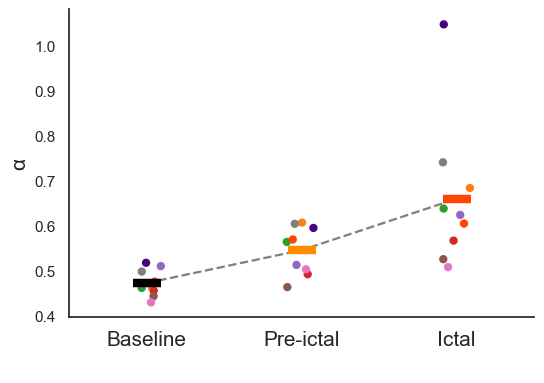

In [101]:
from matplotlib.collections import PathCollection
sns.set(style="white")
colors1 = ['indigo', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', 'orangered', '#17becf', '#1f77b4']
colors2 = ['black','darkorange','orangered']
fig, ax = plt.subplots(figsize = (6,4))
ax = sns.pointplot(x="Labels", y="Exponent", data = exdf, hue = 'Labels', palette = colors2, join=True, ci=0, scale=3, markers='_')
for artist in ax.lines:
    artist.set_zorder(10)
for artist in ax.findobj(PathCollection):
    artist.set_zorder(11)
ax = sns.pointplot(x="Labels", y="Exponent", data = exdf, color = 'grey', linestyles = ["--"], ci = 0, scale=0.6)
ax = sns.stripplot(x="Labels", y="Exponent", data = exdf, hue = 'Fish', palette = colors1, size = 6, jitter = True ,alpha = 1)

points = ax.collections
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(' ', size = '13')
ax.set_ylabel('α', size = '15')
ax.set_xticklabels(['Baseline', 'Pre-ictal', 'Ictal'], size = 15)
ax.legend_.remove()
#plt.hlines(1, -0.05 ,2, linestyle = '--', color = 'grey')
#plt.ylim(0.5,1.3)
plt.show()

In [29]:
adfn.ttest(exdf, 'Labels', 'Exponent', ['Baseline', 'Pre-ictal', 'Ictal'], mode='single')

[[-4.763672304196145,
  0.0014200923265331492,
  0.025,
  'Significant',
  'Baseline - Pre-ictal'],
 [-4.094347619894491,
  0.00346470992100431,
  0.025,
  'Significant',
  'Baseline - Ictal']]

In [152]:
#EXPONENT
import pandas as pd

exp = np.zeros((54))
fli = list(range(18))
flist=[]
count=0
for i in range(9):
    for e in range(2):
        fli[count] = 'F' + str(i+2)
        count+=1
for e in range(3):
    flist = np.append(flist, fli)
    
hue = list(range(18))
huelist=[]
count=0
numcount=0
for i in range(9):
    
    for e in range(2):
        hue[count] = 'Section' + str(e+1)
        count+=1
    
for e in range(3):
    huelist = np.append(huelist, hue)
    
exdf = pd.DataFrame({"Exponent":np.ravel(slope2list) , "Labels":  np.append(adfn.repeat_list('Baseline',18),np.append(adfn.repeat_list('Pre-ictal',18),adfn.repeat_list('Ictal',18))), "Fish":flist, "Hue":huelist})

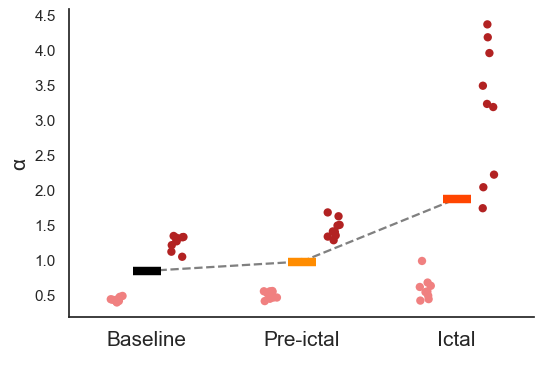

In [153]:
from matplotlib.collections import PathCollection
sns.set(style="white")
colors1 = ['indigo', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', 'orangered', '#17becf', '#1f77b4']
colors2 = ['black','darkorange','orangered']
colors3 = ['lightcoral','firebrick']
fig, ax = plt.subplots(figsize = (6,4))
ax = sns.pointplot(x="Labels", y="Exponent", data = exdf, hue = 'Labels', palette = colors2, join=True, ci=0, scale=3, markers='_')
for artist in ax.lines:
    artist.set_zorder(10)
for artist in ax.findobj(PathCollection):
    artist.set_zorder(11)
ax = sns.pointplot(x="Labels", y="Exponent", data = exdf, color = 'grey', linestyles = ["--"], ci = 0, scale=0.6)
ax = sns.stripplot(x="Labels", y="Exponent", data = exdf, hue = 'Hue', palette = colors3, size = 6, jitter = True ,alpha = 1, dodge=True)

points = ax.collections
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(' ', size = '13')
ax.set_ylabel('α', size = '15')
ax.set_xticklabels(['Baseline', 'Pre-ictal', 'Ictal'], size = 15)
ax.legend_.remove()
#plt.hlines(1, -0.05 ,2, linestyle = '--', color = 'grey')
#plt.ylim(0.5,1.3)
plt.show()

In [ ]:
0.011

In [143]:
adfn.ttest(exdf[:18], 'Hue', 'Exponent', ['Section1', 'Section2'], mode='single')

[[5.190797596884337,
  0.0008316989456200105,
  0.05,
  'Significant',
  'Section1 - Section2']]

In [139]:
adfn.ttest(exdf[18:2*18], 'Hue', 'Exponent', ['Section1', 'Section2'], mode='single')

[[4.815122555790327,
  0.0013296108958090929,
  0.05,
  'Significant',
  'Section1 - Section2']]

In [134]:
adfn.ttest(exdf[2*18:3*18], 'Hue', 'Exponent', ['Section1', 'Section2'], mode='single')

[[8.205967424119752,
  3.634956737339467e-05,
  0.05,
  'Significant',
  'Section1 - Section2']]

In [14]:
comb_list = bln_pcv + pre_pcv + p20_pcv
len(comb_list)

27

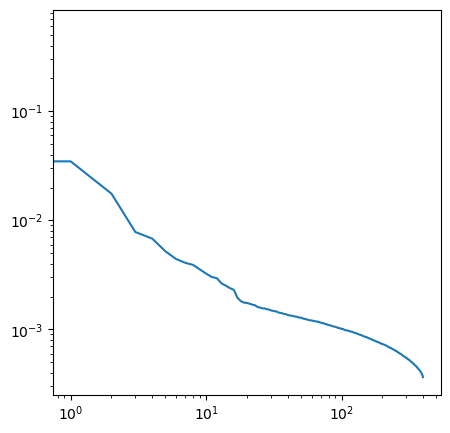

In [31]:
data = bln_pcv[0]
xaxis = np.linspace(0,np.shape(data)[0]-1, num = np.shape(data)[0])
yaxis = data
fig, axarr = plt.subplots(figsize = (5,5))
plt.plot(xaxis[:len(xaxis)-1], yaxis[:len(xaxis)-1])
axarr.set_xscale('log')
axarr.set_yscale('log')
plt.show()

In [53]:
diff_list = list(range(len(comb_list)))
maxind_list = list(range(len(comb_list)))
for i in range(len(comb_list)):
    data = comb_list[i][:200]
    xaxis = np.linspace(0,np.shape(data)[0]-1, num = np.shape(data)[0])
    yaxis = data
    diff_list[i] = slope_split(xaxis, yaxis, 3, 5)
    maxind_list[i] = np.where(diff_list[i] == np.max(diff_list[i]))[0][0]
    
diff_mat = np.asarray(diff_list)
sum_vec = np.apply_along_axis(np.mean, 0, diff_mat)

In [58]:
np.where(sum_vec == np.max(sum_vec))


(array([0]),)

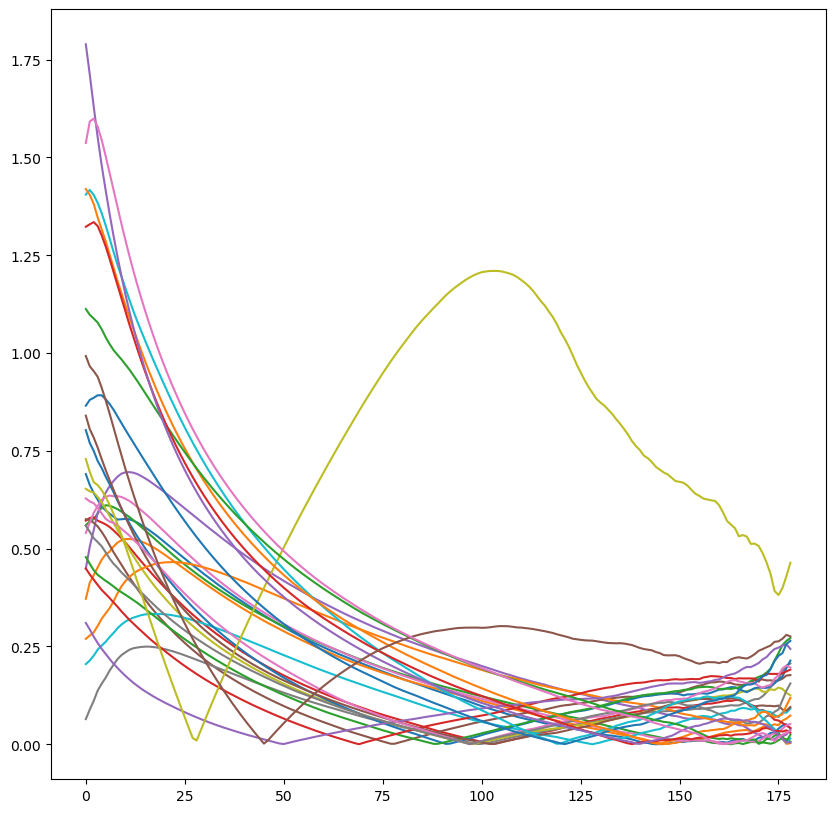

In [54]:
fig, axarr = plt.subplots(figsize = (10,10))
for i in range(len(diff_list)): 
    data = diff_list[i]
    xaxis = np.linspace(0,np.shape(data)[0]-1, num = np.shape(data)[0])
    yaxis = data
    plt.plot(xaxis[:len(xaxis)-1], yaxis[:len(xaxis)-1])
plt.show()

In [10]:
#Find maximal slope difference
def slope_split(xaxis, yaxis, xmin, perc_start):
    import numpy as np
    xmin = 1
    start = int(np.percentile(xaxis, perc_start)) #find lowest point of distribution to split
    end = int(np.percentile(xaxis, 100-perc_start)) #find highest point of distribution to split
    diff_list = list(range(end-start))
    count=0
    for i in range(start,end):
        diff_list[count] = abs((-1* stats.linregress(np.log10(xaxis[xmin:i]),np.log10(yaxis[xmin:i]))[0]) - (-1* stats.linregress(np.log10(xaxis[i:]),np.log10(yaxis[i:]))[0]))
        count+=1
    return(diff_list)

